# 机器学习纳米学位
## 猫狗大战 Dog vs Cat
### 一、 分析数据，准备数据
首先从[kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)上下载好数据包:test.zip和train.zip，对包进行解压缩与数据预处理。
#### 1、解压缩文件
注意将zip文件放到该ipythonnotebook同级别目录下：

In [1]:
import zipfile
import os
def un_zip(file_name):  
    """unzip zip file"""
    if not os.path.isdir(file_name):
        zip_file = zipfile.ZipFile(file_name+".zip")  
        zip_file.extractall()
        zip_file.close()
train_dir = 'train'
test_dir = 'test'
un_zip(test_dir)
un_zip(train_dir)

观察解压出来的数据，可以看到数据名字格式，例如训练集中cat.0.jpg表示猫分类的第一张图，同理dog.0.jpg表示狗分类的第一张图，数字从0一直持续到12499，猫和狗各12500张，测试集中类似，只是没有猫狗的标记，图像只是以数字计算，一共有12500张测试图片。
#### 2、 建立分类目录

我们为数据文件建立symbol link并划分为训练集,测试集，为模型训练和特征提取打好基础。

In [2]:
import shutil
import os
from tqdm import tqdm

work_dir  = os.getcwd()
train_dir = work_dir + '/train/'
test_dir = work_dir + '/test/'
# 建立link根目录
imglink_dir = work_dir + "/img_link/"
if(os.path.exists(imglink_dir)):
    shutil.rmtree(imglink_dir)
os.mkdir(imglink_dir)
# 建立特征提取训练集目录
img_train2 = imglink_dir + "train2/"
os.mkdir(img_train2)
os.mkdir(img_train2 + "cat/")
os.mkdir(img_train2 + "dog/")
# 建立测试集目录
img_test  = imglink_dir + "test/"
os.mkdir(img_test)
os.mkdir(imglink_dir + "test/mixed/")
# 建立模型训练训练集 验证集目录，测试集目录共用一个
img_train = imglink_dir + "train/"
os.mkdir(img_train)
img_valid = imglink_dir + "valid/"
os.mkdir(img_valid)
img_train_cat = img_train + "cat/"
os.mkdir(img_train_cat)
img_train_dog = img_train + "dog/"
os.mkdir(img_train_dog)
img_valid_cat = img_valid + "cat/"
os.mkdir(img_valid_cat)
img_valid_dog = img_valid + "dog/"
os.mkdir(img_valid_dog)

In [3]:
#link test
test_filenames = os.listdir(test_dir)
num_test = len(test_filenames)

for i in tqdm(range(num_test)): 
    os.symlink(test_dir + test_filenames[i], img_test + "mixed/" + test_filenames[i])

100%|██████████| 12500/12500 [00:00<00:00, 98014.61it/s]


#### 3、 数据研究
先来展示下咱们的训练数据

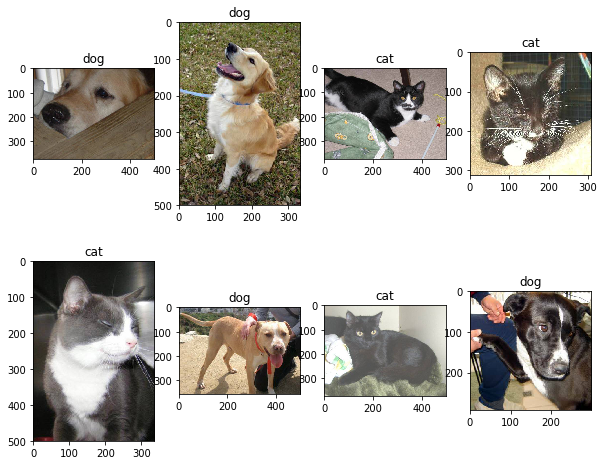

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
for i, file in enumerate(os.listdir(train_dir)[:8]):
    img = plt.imread(os.path.join(train_dir, file))
    plt.subplot(2, 4, i+1)
    plt.title(file.split('.')[0])
    plt.axis('on')
    plt.imshow(img)
plt.show()

从上面的图示的结果来看，可以看出每张图片并不像我们预想的分辨率都一样大，那么，让获取每张图片的分辨率以及通道数，来对分辨率进行统计分析。

In [5]:
import os
import cv2
from tqdm import tqdm

train_info = [[],[]]
outside = []
train_img_list = list(filter(lambda x:x[-3:] == 'jpg', os.listdir(train_dir)))
for img in tqdm(train_img_list):
    info = cv2.imread(os.path.join(train_dir, img))
    train_info[0].append(info.shape[0])
    train_info[1].append(info.shape[1])
    if(info.shape[0] > 600):
        outside.append(train_dir+img)

100%|██████████| 25000/25000 [00:39<00:00, 638.66it/s]


In [6]:
print(outside)

['/home/willow/p7/dogvscat/train/dog.2317.jpg', '/home/willow/p7/dogvscat/train/cat.835.jpg']


图示化分析图片的分辨率

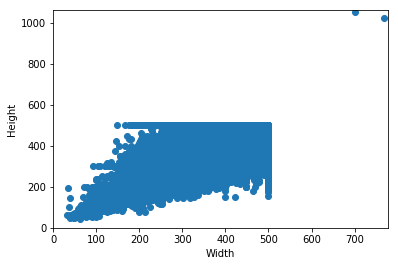

In [7]:
plt.scatter(train_info[0], train_info[1])
plt.xlabel('Width')
plt.ylabel('Height') 
plt.xlim(0,max(train_info[0]) + 10)
plt.ylim(0,max(train_info[1]) + 10)  
plt.show()

从图表中可以看出图片的宽度和高度基本都遍布在100-500之间。

删除那两张超出平均分辨率很多的图片

In [8]:
for img in outside:
    os.remove(img)

#### 4、数据预处理
为了尽量利用我们有限的训练数据，我们将通过一系列随机变换堆数据进行提升，这样我们的模型将看不到任何两张完全相同的图片，这有利于我们抑制过拟合，使得模型的泛化能力更好。

这个步骤可以通过keras.preprocessing.image.ImageGenerator来实现，下面我们来展示下这个预处理函数实现后的结果。

Using TensorFlow backend.


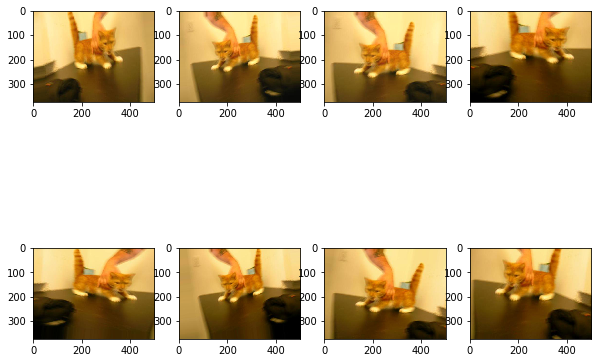

In [9]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import os

temp = ImageDataGenerator(
                        rotation_range = 10,
                        zoom_range = 0.2,
                        width_shift_range = 0.05,
                        height_shift_range = 0.1,
                        channel_shift_range=10,
                        horizontal_flip=True)

img = load_img(train_dir + '/cat.0.jpg')  
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)

if(os.path.exists("preview")):
    shutil.rmtree("preview")
os.mkdir("preview")
i = 0
for batch in temp.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i >= 8:
        break

plt.figure(figsize=(10, 8))
for i, file in enumerate(os.listdir("preview")):
    img = plt.imread(os.path.join("preview", file))
    plt.subplot(2, 4, i+1)
    plt.axis('on')
    plt.imshow(img)
plt.show()

接着要进行我们的数据清洗工作，因为我们的图片保不齐有一些图并不是我们的猫狗类别的图像，这样对我们的算法上可能会造成一些影响，所以要对不是猫狗的图进行一下清洗。清洗的方法参考[这个链接](https://zhuanlan.zhihu.com/p/34068451)，使用imagenet上top几来进行分类。我还找到了一个[马桶的例子](https://blog.csdn.net/lauyeed/article/details/78886830)，感觉也很实用。

首先把前辈整理好的猫狗种类偷下来整理成列表。

In [10]:
dogs_cats = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978','n02123045','n02123159'
,'n02123394','n02123597','n02124075','n02125311'
,'n02127052']

查找，显示，并删除异常数据。

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions 
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
import numpy as np
def find_dirty_img(train_dir, dogs_cats,top = 10):
    dirty_imgs = []
    pathlist = os.listdir(train_dir)
    model = ResNet50(weights='imagenet')
    for i in pathlist:
        img = image.load_img(train_dir + i, target_size=(224, 224))  
        img = image.img_to_array(img)  
        x = np.expand_dims(img, axis=0)  
        x = preprocess_input(x)  
        preds = model.predict(x)
        preds = decode_predictions(preds, top=top)[0] 
        preds_list = list(zip(*preds))[0]
        if set(preds_list)&set(dogs_cats):
            continue
        else:
            dirty_imgs.append(train_dir + i)
            imgs = cv2.imread(train_dir + i)
            b,g,r = cv2.split(imgs)
            imgs = cv2.merge([r,g,b])
            plt.imshow(imgs)
            plt.axis('on')
            plt.title(i)
            plt.show()
    return dirty_imgs

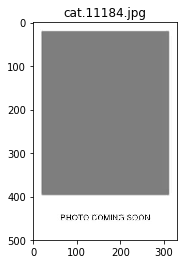

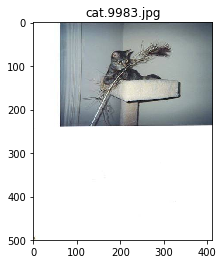

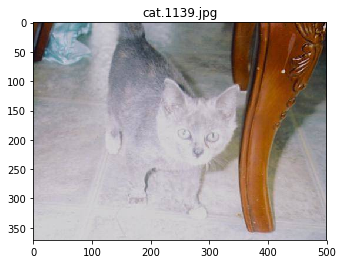

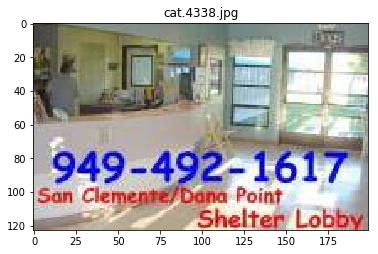

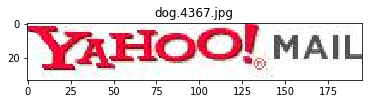

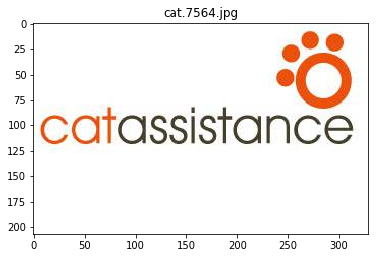

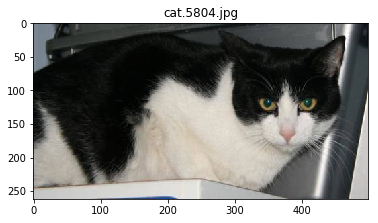

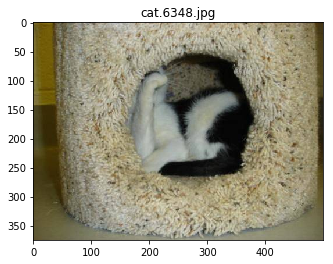

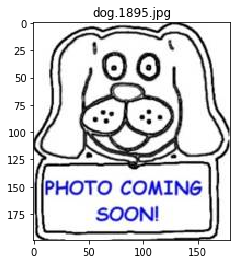

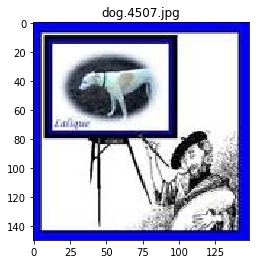

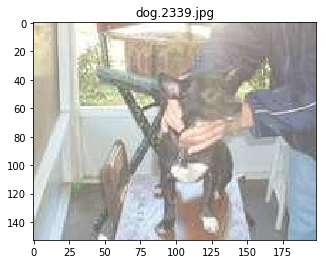

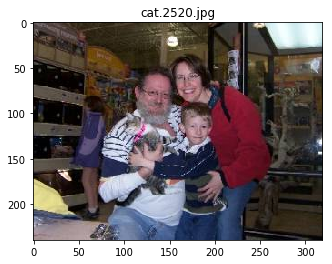

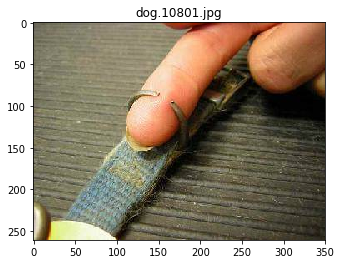

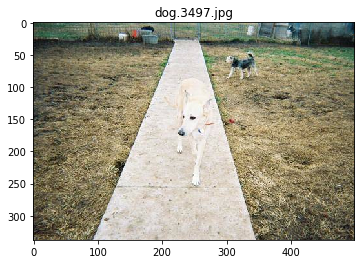

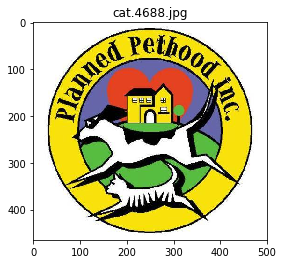

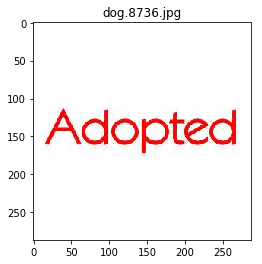

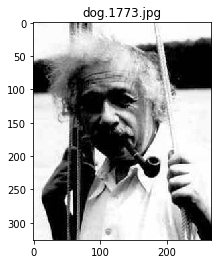

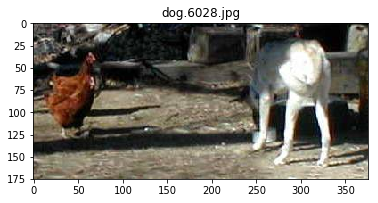

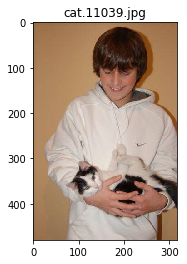

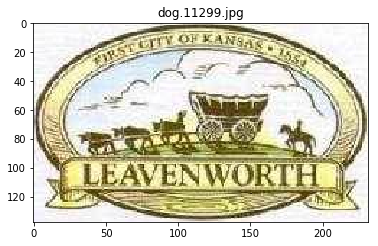

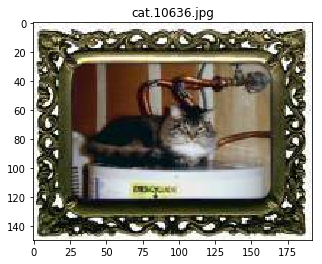

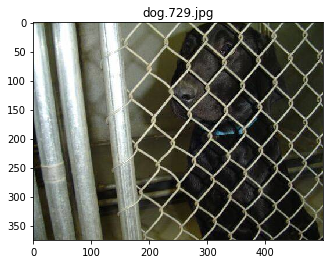

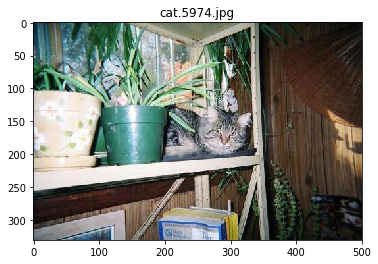

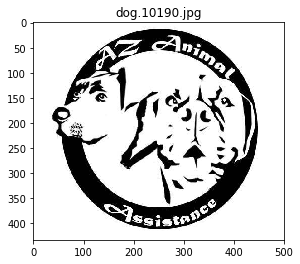

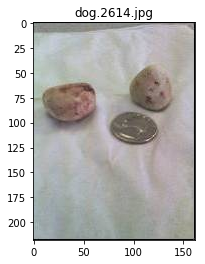

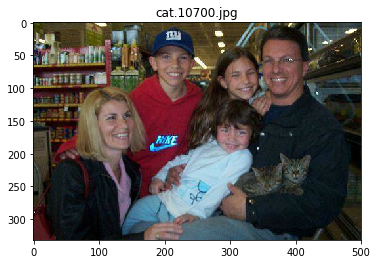

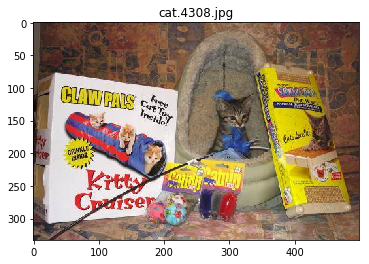

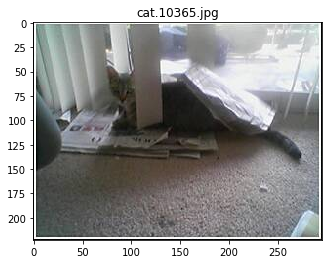

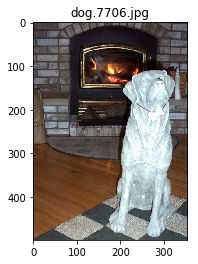

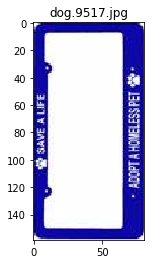

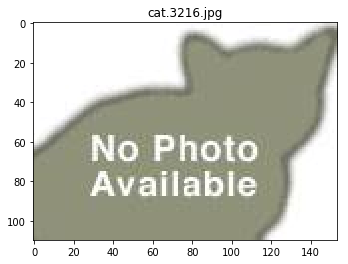

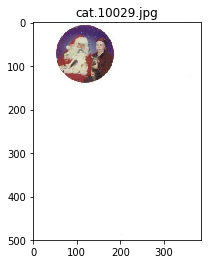

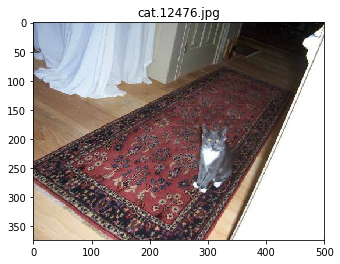

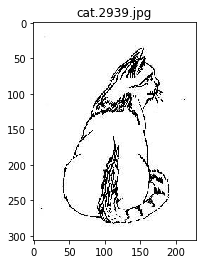

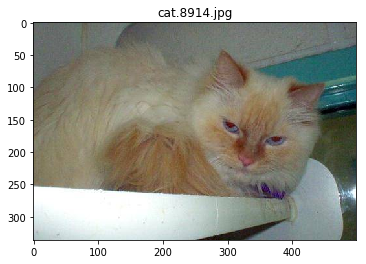

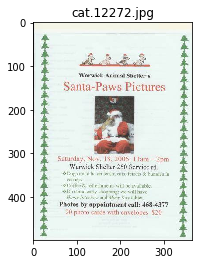

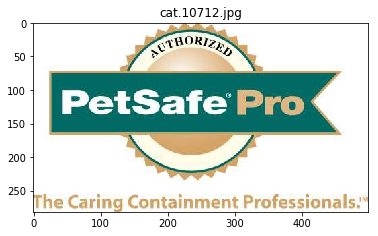

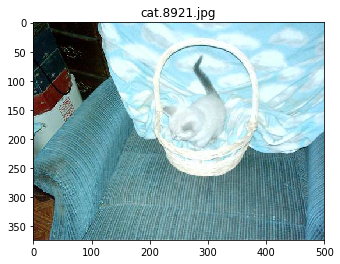

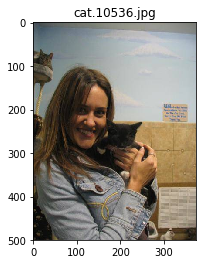

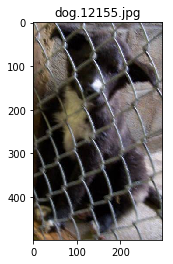

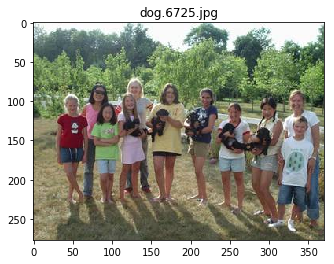

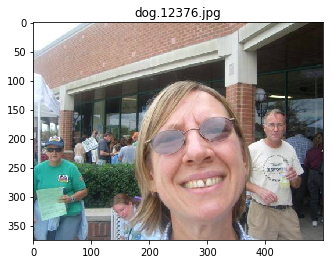

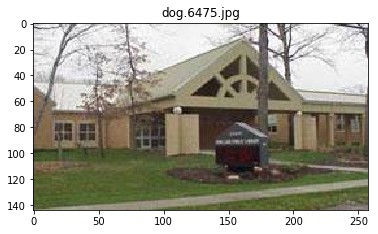

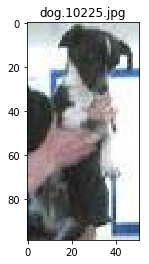

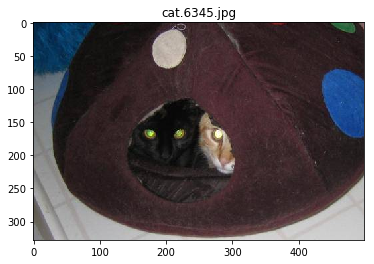

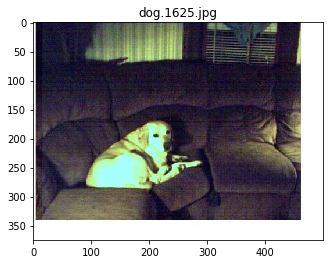

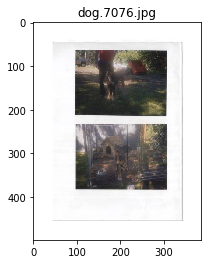

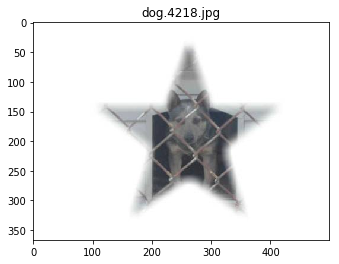

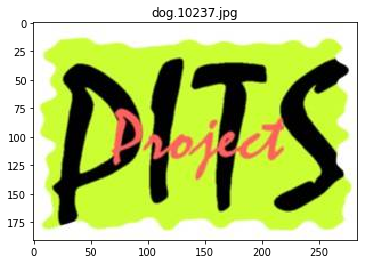

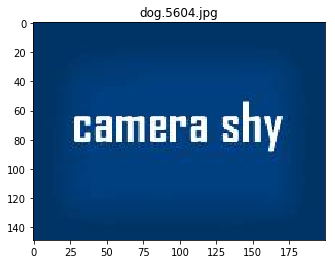

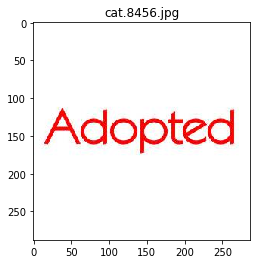

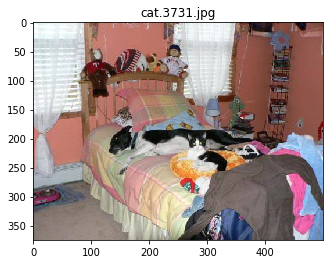

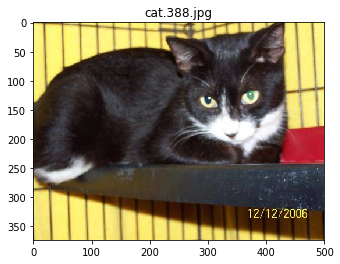

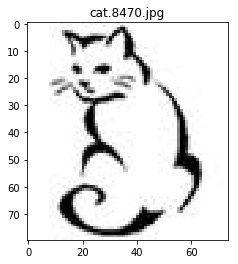

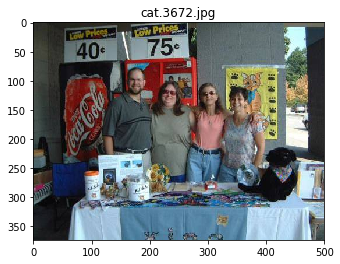

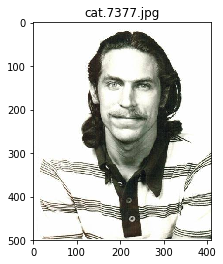

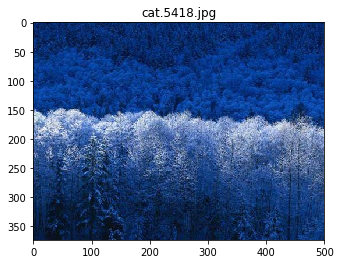

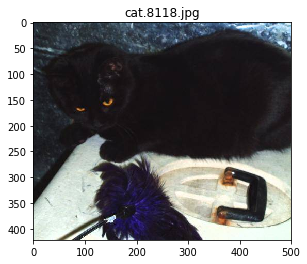

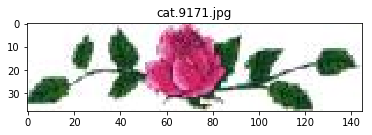

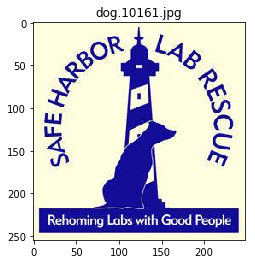

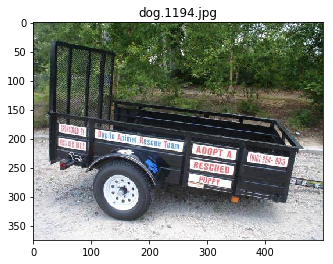

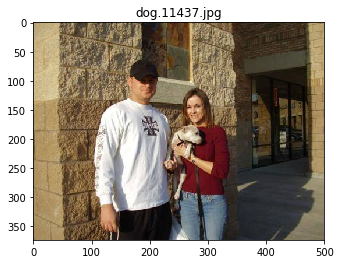

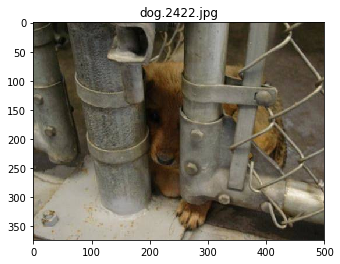

In [12]:
dirty_imgs = find_dirty_img(train_dir, dogs_cats, top = 35)

In [13]:
print(dirty_imgs, len(dirty_imgs))

['/home/willow/p7/dogvscat/train/cat.11184.jpg', '/home/willow/p7/dogvscat/train/cat.9983.jpg', '/home/willow/p7/dogvscat/train/cat.1139.jpg', '/home/willow/p7/dogvscat/train/cat.4338.jpg', '/home/willow/p7/dogvscat/train/dog.4367.jpg', '/home/willow/p7/dogvscat/train/cat.7564.jpg', '/home/willow/p7/dogvscat/train/cat.5804.jpg', '/home/willow/p7/dogvscat/train/cat.6348.jpg', '/home/willow/p7/dogvscat/train/dog.1895.jpg', '/home/willow/p7/dogvscat/train/dog.4507.jpg', '/home/willow/p7/dogvscat/train/dog.2339.jpg', '/home/willow/p7/dogvscat/train/cat.2520.jpg', '/home/willow/p7/dogvscat/train/dog.10801.jpg', '/home/willow/p7/dogvscat/train/dog.3497.jpg', '/home/willow/p7/dogvscat/train/cat.4688.jpg', '/home/willow/p7/dogvscat/train/dog.8736.jpg', '/home/willow/p7/dogvscat/train/dog.1773.jpg', '/home/willow/p7/dogvscat/train/dog.6028.jpg', '/home/willow/p7/dogvscat/train/cat.11039.jpg', '/home/willow/p7/dogvscat/train/dog.11299.jpg', '/home/willow/p7/dogvscat/train/cat.10636.jpg', '/home/

可以看到共筛选出63个异常值，有些人多于宠物的，有些是奇怪图形的等等，我们现在将他们从文件中删除。

In [14]:
for img in dirty_imgs:
    os.remove(img)

删除后的文件总数有24935个。

In [17]:
train_list = os.listdir(train_dir)
len(train_list)

24935

在剔除脏文件后，我们对train的文件进行链接，用来做后面的算法实施。

In [15]:
# symbol link train2
train_filenames = os.listdir(train_dir)
train_cat = list(filter(lambda x:x[:3] == 'cat', train_filenames))
train_dog = list(filter(lambda x:x[:3] == 'dog', train_filenames))

for i in tqdm(range(len(train_cat))):
    os.symlink(train_dir + train_cat[i], img_train2 + "cat/" + train_cat[i])
for i in tqdm(range(len(train_dog))):
    os.symlink(train_dir + train_dog[i], img_train2 + "dog/" + train_dog[i])

100%|██████████| 12470/12470 [00:00<00:00, 95303.03it/s]


In [16]:
#link valid train
for i in tqdm(range(len(train_cat))):
    if i < (len(train_cat) * 0.2):
        os.symlink(train_dir + train_cat[i], img_valid_cat + train_cat[i])
    else:
        os.symlink(train_dir + train_cat[i], img_train_cat + train_cat[i])
for i in tqdm(range(len(train_dog))):
    if i < (len(train_cat) * 0.2):
        os.symlink(train_dir + train_dog[i], img_valid_dog+ train_dog[i])
    else:
        os.symlink(train_dir + train_dog[i], img_train_dog + train_dog[i])

100%|██████████| 12470/12470 [00:00<00:00, 92777.71it/s]


### 二、算法实施
### 类构建
我首先实现一个类，可以进行对一些基础模型进行迁移，和fine-tune的操作。为后面的模型训练提取等做准备

In [18]:
import numpy as np
from keras.layers import *
from keras.preprocessing.image import *
from keras.models import *
from keras.callbacks import *
import matplotlib.pyplot as plt
import pandas as pd
from keras.applications import *

class CNN(object):
    np.random.seed(23)

    def __init__(self, model, train_dir, val_dir, test_dir, train_full_dir, batch_size=32,
                 img_sz=(224, 224), preprocess_func=None):
        self.train_dir = train_dir
        self.train_full_dir = train_full_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.img_sz = img_sz
        if preprocess_func:
            self.preprocess_input = preprocess_func

        train_generator = ImageDataGenerator(
            preprocessing_function=self.preprocess_input,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True)
        self.train_ge = train_generator.flow_from_directory(
            self.train_dir,
            target_size=self.img_sz,
            batch_size=batch_size,
            shuffle=True,
            class_mode='binary')

        val_generator = ImageDataGenerator(preprocessing_function=self.preprocess_input)
        self.val_ge = val_generator.flow_from_directory(
            self.val_dir,
            target_size=self.img_sz,
            batch_size=batch_size,
            shuffle=True,
            class_mode='binary')

        self.test_ge = val_generator.flow_from_directory(
            self.test_dir,
            target_size=self.img_sz,
            batch_size=batch_size,
            shuffle=False,
            class_mode=None)

        input_tensor = Input((img_sz[0], img_sz[1], 3))
        self.base_model = model(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling = 'avg')
        self.model_name = self.base_model.name
        for layer in self.base_model.layers:
            layer.trainable = False

        x = self.base_model.output
        x = Dropout(0.5)(x)

        output = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=self.base_model.input, outputs=output)
        self.model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    def fit(self, epochs = 5, steps_train = 650, steps_valid = 150):
        check_point = ModelCheckpoint(
            self.model_name +'_'+'freeze_base.hdf5',
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True)

        self.result = self.model.fit_generator(
            self.train_ge,
            steps_per_epoch=steps_train,
            epochs=epochs,
            validation_data=self.val_ge,
            validation_steps=steps_valid,
            callbacks=[check_point])
    def visualization(self):
        history = self.result.history
        fig = plt.figure(figsize=(8, 5))

        y1 = fig.add_subplot(111)
        p1 = y1.plot(history['val_loss'], label="val_loss", color='r')
        y1.set_ylabel('binary_crossentropy')
        y1.set_xlabel('epochs')
        y2 = y1.twinx()
        p2 = y2.plot(history['val_acc'], label="val_acc", color='b')
        y2.set_ylabel('accuracy')
        lns = p1+p2
        labs = [l.get_label() for l in lns]
        y1.legend(lns, labs, loc='center right')
        plt.show()
    def load_weight(self, filename):
        self.model.load_weights(filename)
    def fit_finetune(self, fine_tune_layer, filename = None, epochs = 5, steps_train = 1000, steps_valid = 100):
        if filename != None:
            self.model.load_weights(filename)
        for layer in self.model.layers:
            layer.trainable = False
        for layer in self.model.layers[-fine_tune_layer:]:
            layer.trainable = True
        self.model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
        check_point = ModelCheckpoint(
            self.model_name + '_finetune_' + str(fine_tune_layer) +'.hdf5',
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True)

        self.result = self.model.fit_generator(
            self.train_ge,
            steps_per_epoch=steps_train,
            epochs=epochs,
            validation_data=self.val_ge,
            validation_steps=steps_valid,
            callbacks=[check_point])

    def summary(self):
        self.model.summary()

    def predict(self, name = None):
        self.predict_ge = self.model.predict_generator(self.test_ge, verbose=1)
        self.predict_ge = self.predict_ge.clip(min=0.005, max=0.995)
        if name == None:
            name = "1"
        df = pd.read_csv("sample_submission.csv")
        for i, fname in enumerate(self.test_ge.filenames):
            index = int(fname.split('/')[1].split('.')[0])
            df.set_value(index - 1, 'label', self.predict_ge[i])

        outfile = 'pred_' + self.model_name + name + '.csv'
        print('Saving test result on: ' + outfile)
        df.to_csv(outfile, index=None)
        print("save_predict in: " + outfile)
        return df

    def write_feature(self, name = None):
        model = Model(self.model.input, self.model.layers[-3].output)
        print('The output of model: ', model.output)
        if name == None:
            name = self.model_name
        else:
            name = self.model_name + name
        print('Data augmentation')
        gen = ImageDataGenerator(
            preprocessing_function=self.preprocess_input,
        )

        train_gen = gen.flow_from_directory(
            self.train_full_dir,
            target_size=self.img_sz,
            shuffle=False,
            batch_size=128,
        )

        self.train_gen_full = train_gen
        test_gen = self.test_ge

        print('feature from train data ...' )
        train = model.predict_generator(train_gen, verbose=1)
        print('feature from test data ...' )
        test = model.predict_generator(test_gen, verbose=1)

        fn = "feature_%s.hdf5"%name
        print('Write feature to file: ' + fn)
        with h5py.File(fn) as h:
            h.create_dataset("train", data=train)
            h.create_dataset("label", data=train_gen.classes)
            h.create_dataset("test", data=test)

### 单模型提取特征向量
### 1. Xception

In [19]:
cnn_xception = CNN(xception.Xception, img_train, img_valid, img_test, img_train2,
               batch_size=128, img_sz=(299, 299), preprocess_func= xception.preprocess_input)

Found 19949 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


先来看下模型信息:

In [20]:
cnn_xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

提取特征向量：

In [21]:
cnn_xception.write_feature()

The output of model:  Tensor("global_average_pooling2d_1/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 178s 912ms/step
feature from test data ...
98/98 [==============================] - 89s 907ms/step
Write feature to file: feature_xception.hdf5


### 2. ResNet50

In [22]:
from keras.applications import imagenet_utils

In [23]:
cnn_resnet50 = CNN(resnet50.ResNet50, img_train, img_valid, img_test, img_train2,
                batch_size=128, preprocess_func= imagenet_utils.preprocess_input)

Found 19949 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


先来看下模型信息:

In [24]:
cnn_resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

提取特征向量：

In [25]:
cnn_resnet50.write_feature()

The output of model:  Tensor("global_average_pooling2d_2/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 151s 775ms/step
feature from test data ...
98/98 [==============================] - 77s 782ms/step
Write feature to file: feature_resnet50.hdf5


### 3. InceptionV3

In [20]:
cnn_inceptionv3 = CNN(inception_v3.InceptionV3, img_train, img_valid, img_test, img_train2,
                   batch_size=128, preprocess_func= inception_v3.preprocess_input)

Found 19949 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


先来看下模型信息:

In [21]:
cnn_inceptionv3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 111, 111, 32) 96          conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_106 (Activation)     (None, 111, 111, 32) 0           batch_normalization_58[0][0]     
__________________________________________________________________________________________________
conv2d_59 

提取特征向量：

In [22]:
cnn_inceptionv3.write_feature()

The output of model:  Tensor("global_average_pooling2d_1/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 148s 762ms/step
feature from test data ...
98/98 [==============================] - 73s 741ms/step
Write feature to file: feature_inception_v3.hdf5


### 构建基础融合模型
### 1. 模型可视化

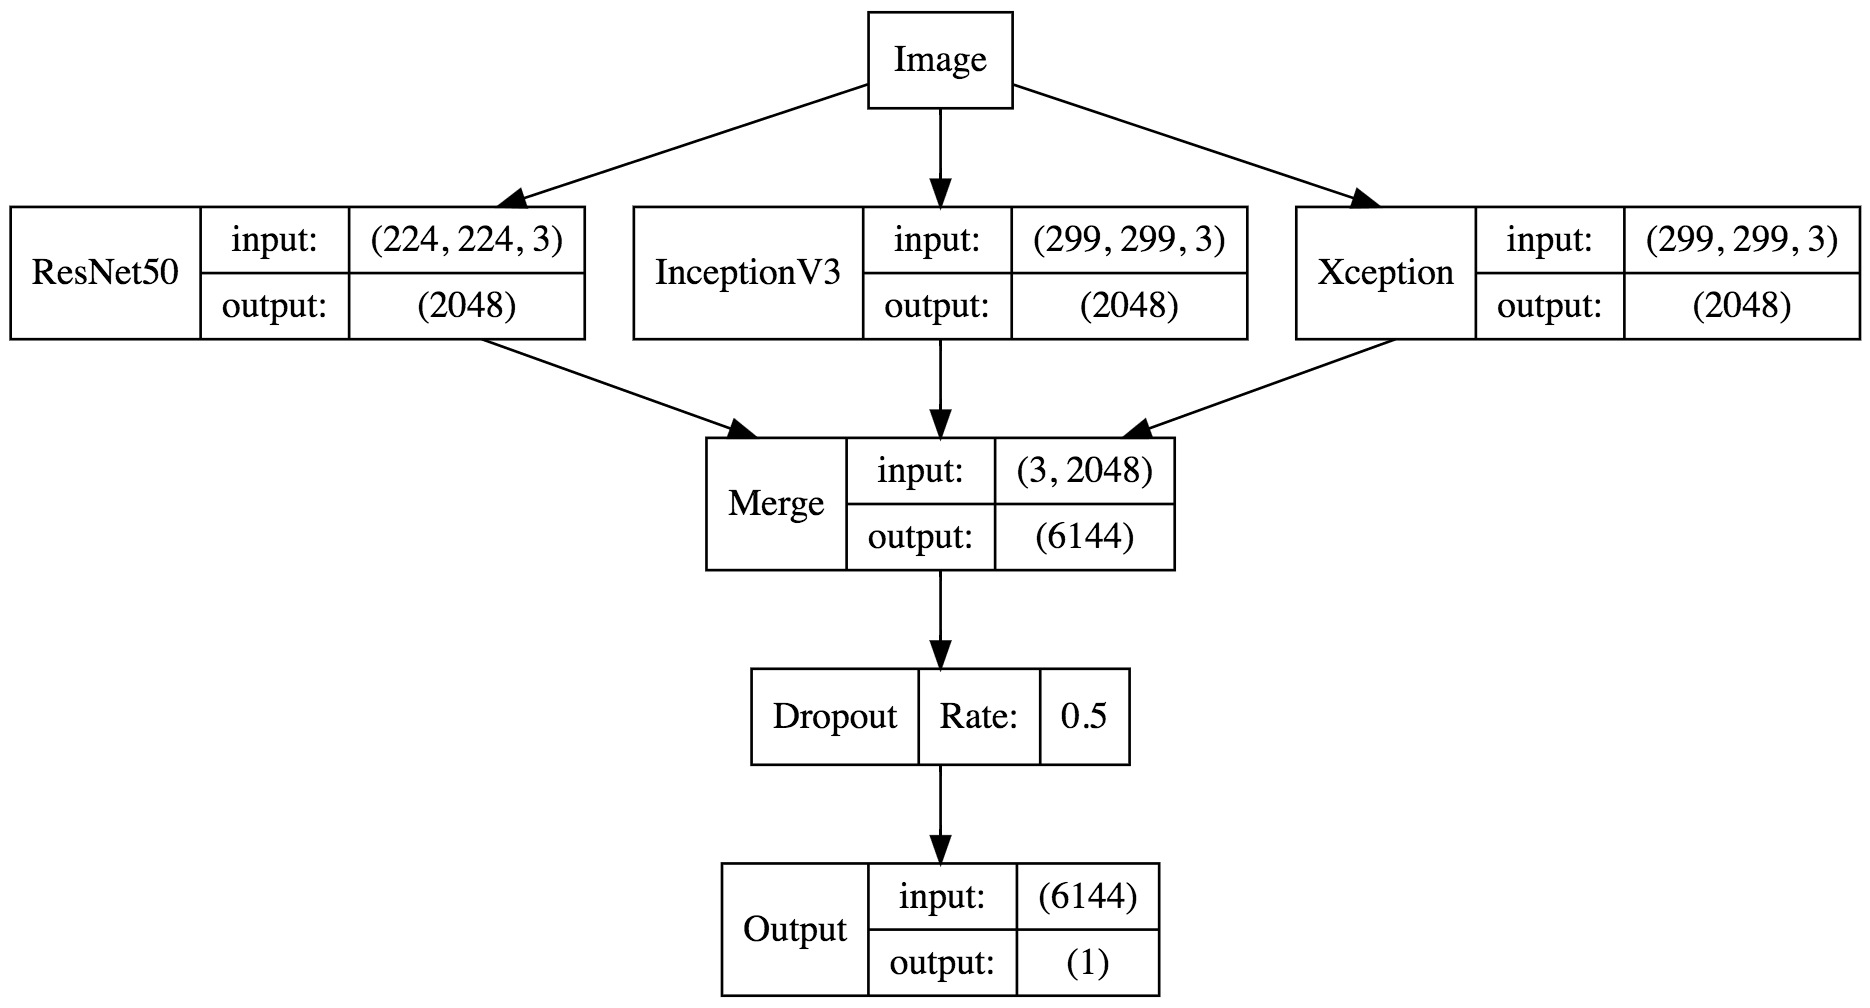

### 2. 模型构建并训练
基于这些导出的特征，我们构建并训练猫狗问题的模型。在此，我们只需要给出全连接层即可。

In [30]:
import h5py
from sklearn.utils import shuffle

np.random.seed(23)

X_train = []
X_test = []

for filename in ["feature_inception_v3.hdf5", "feature_resnet50.hdf5", "feature_xception.hdf5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        Y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, Y_train = shuffle(X_train, Y_train)

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

训练这个融合模型：

In [31]:
checkpoint = ModelCheckpoint("merge_base.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]
result = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True,
         callbacks=callbacks_list)

Train on 19948 samples, validate on 4987 samples
Epoch 1/20
19948/19948 [==============================] - 3s 166us/step - loss: 0.0792 - acc: 0.9718 - val_loss: 0.0217 - val_acc: 0.9944

Epoch 00001: val_loss improved from inf to 0.02170, saving model to merge_base.h5
Epoch 2/20
19948/19948 [==============================] - 1s 41us/step - loss: 0.0239 - acc: 0.9918 - val_loss: 0.0175 - val_acc: 0.9948

Epoch 00002: val_loss improved from 0.02170 to 0.01748, saving model to merge_base.h5
Epoch 3/20
19948/19948 [==============================] - 1s 40us/step - loss: 0.0187 - acc: 0.9935 - val_loss: 0.0165 - val_acc: 0.9948

Epoch 00003: val_loss improved from 0.01748 to 0.01649, saving model to merge_base.h5
Epoch 4/20
19948/19948 [==============================] - 1s 40us/step - loss: 0.0162 - acc: 0.9947 - val_loss: 0.0167 - val_acc: 0.9944

Epoch 00004: val_loss did not improve from 0.01649
Epoch 5/20
19948/19948 [==============================] - 1s 40us/step - loss: 0.0152 - acc: 

展示下每个epoch的训练成果：

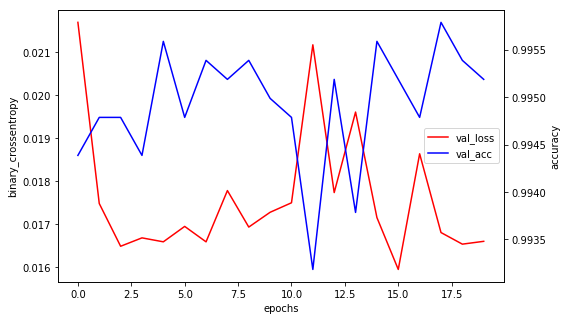

In [32]:
history = result.history
fig = plt.figure(figsize=(8, 5))

y1 = fig.add_subplot(111)
p1 = y1.plot(history['val_loss'], label="val_loss", color='r')
y1.set_ylabel('binary_crossentropy')
y1.set_xlabel('epochs')
y2 = y1.twinx()
p2 = y2.plot(history['val_acc'], label="val_acc", color='b')
y2.set_ylabel('accuracy')
lns = p1+p2
labs = [l.get_label() for l in lns]
y1.legend(lns, labs, loc='center right')
plt.show()

用最好的weight在测试集上进行预测：

In [33]:
#导入模型权重，并进行预测    
model.load_weights('merge_base.h5')
y_test = model.predict(X_test, verbose=1)
y_test = y_test.clip(min=0.005, max=0.995)
df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(img_test, (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_test[i])

df.to_csv('pred-merge.csv', index=None)
df.head(10)

12500/12500 [==============================] - 2s 139us/step
Found 12500 images belonging to 1 classes.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

提交kaggle得分：0.04135

### 单模型fine-tune并提取特征向量
### 1. Xception
训练冻结所有层的模型:

In [34]:
cnn_xception.fit(epochs= 5)

Epoch 1/5
650/650 [==============================] - 1888s 3s/step - loss: 0.0911 - acc: 0.9760 - val_loss: 0.0658 - val_acc: 0.9846

Epoch 00001: val_loss improved from inf to 0.06584, saving model to xception_freeze_base.hdf5
Epoch 2/5
650/650 [==============================] - 1858s 3s/step - loss: 0.0436 - acc: 0.9856 - val_loss: 0.0594 - val_acc: 0.9848

Epoch 00002: val_loss improved from 0.06584 to 0.05940, saving model to xception_freeze_base.hdf5
Epoch 3/5
650/650 [==============================] - 1862s 3s/step - loss: 0.0399 - acc: 0.9862 - val_loss: 0.0599 - val_acc: 0.9847

Epoch 00003: val_loss did not improve from 0.05940
Epoch 4/5
650/650 [==============================] - 1856s 3s/step - loss: 0.0381 - acc: 0.9869 - val_loss: 0.0595 - val_acc: 0.9843

Epoch 00004: val_loss did not improve from 0.05940
Epoch 5/5
650/650 [==============================] - 1864s 3s/step - loss: 0.0366 - acc: 0.9872 - val_loss: 0.0548 - val_acc: 0.9852

Epoch 00005: val_loss improved from 

可视化：

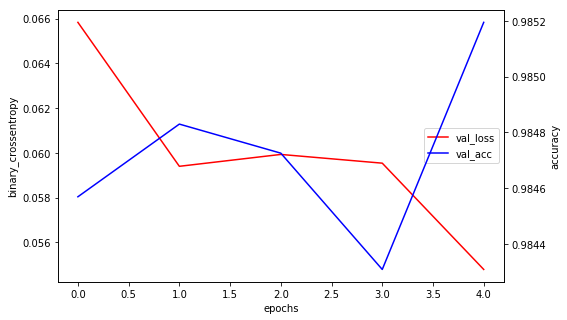

In [35]:
cnn_xception.visualization()

用全冻结层来进行预测：

In [36]:
cnn_xception.load_weight('xception_freeze_base.hdf5')

In [37]:
cnn_xception.predict(name = 'base')

98/98 [==============================] - 90s 917ms/step
Saving test result on: pred_xceptionbase.csv
save_predict in: pred_xceptionbase.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:135: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id     label
0          1  0.993960
1          2  0.995000
2          3  0.995000
3          4  0.994870
4          5  0.005000
5          6  0.005000
6          7  0.005000
7          8  0.005000
8          9  0.005000
9         10  0.005000
10        11  0.005000
11        12  0.882725
12        13  0.005000
13        14  0.005000
14        15  0.005000
15        16  0.005000
16        17  0.685916
17        18  0.995000
18        19  0.005000
19        20  0.005000
20        21  0.995000
21        22  0.005000
22        23  0.995000
23        24  0.989678
24        25  0.005000
25        26  0.990533
26        27  0.976630
27        28  0.005000
28        29  0.005000
29        30  0.952707
...      ...       ...
12470  12471  0.987522
12471  12472  0.910916
12472  12473  0.005000
12473  12474  0.005000
12474  12475  0.005000
12475  12476  0.995000
12476  12477  0.995000
12477  12478  0.128715
12478  12479  0.005000
12479  12480  0.005000
12480  12481  0.005000
12481  12482  0.005000
12482  12483  0.005000
12483  12484  0.978522
12484  12485  0.005000
12485  12486  0.994343
12486  12487  0.984078
12487  12488  0.978264
12488  12489  0.976885
12489  12490  0.554322
12490  12491  0.779117
12491  12492  0.990146
12492  12493  0.941369
12493  12494  0.983876
12494  12495  0.005000
12495  12496  0.005000
12496  12497  0.005000
12497  12498  0.854243
12498  12499  0.995000
12499  12500  0.005000

[12500 rows x 2 columns]

kaggle得分：0.08010

finetune最后28层，使用上面fit训练的最好的模型来进行finetune，finetune5次。

In [38]:
cnn_xception.fit_finetune(28, epochs = 5)

Epoch 1/5
1000/1000 [==============================] - 2790s 3s/step - loss: 0.0095 - acc: 0.9967 - val_loss: 0.0398 - val_acc: 0.9923

Epoch 00001: val_loss improved from inf to 0.03984, saving model to xception_finetune_28.hdf5
Epoch 2/5
1000/1000 [==============================] - 2765s 3s/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0182 - val_acc: 0.9970

Epoch 00002: val_loss improved from 0.03984 to 0.01819, saving model to xception_finetune_28.hdf5
Epoch 3/5
1000/1000 [==============================] - 2763s 3s/step - loss: 6.8868e-04 - acc: 0.9998 - val_loss: 0.0143 - val_acc: 0.9963

Epoch 00003: val_loss improved from 0.01819 to 0.01434, saving model to xception_finetune_28.hdf5
Epoch 4/5
1000/1000 [==============================] - 2763s 3s/step - loss: 5.5948e-04 - acc: 0.9998 - val_loss: 0.0136 - val_acc: 0.9966

Epoch 00004: val_loss improved from 0.01434 to 0.01364, saving model to xception_finetune_28.hdf5
Epoch 5/5
1000/1000 [==============================] - 2768s

可视化：

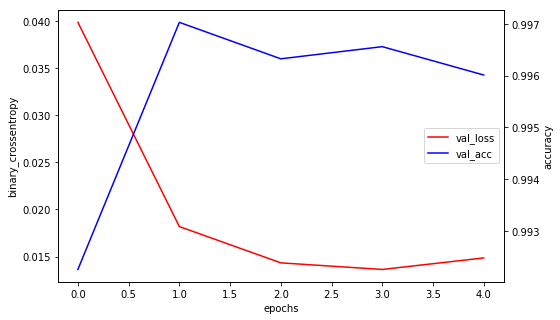

In [39]:
cnn_xception.visualization()

看下这个模型的测试结果：

In [40]:
cnn_xception.load_weight('xception_finetune_28.hdf5')

In [41]:
cnn_xception.predict(name = 'fine')

98/98 [==============================] - 91s 924ms/step
Saving test result on: pred_xceptionfine.csv
save_predict in: pred_xceptionfine.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:135: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id  label
0          1  0.995
1          2  0.995
2          3  0.995
3          4  0.995
4          5  0.005
5          6  0.005
6          7  0.005
7          8  0.005
8          9  0.005
9         10  0.005
10        11  0.005
11        12  0.995
12        13  0.005
13        14  0.005
14        15  0.005
15        16  0.005
16        17  0.995
17        18  0.995
18        19  0.005
19        20  0.005
20        21  0.995
21        22  0.005
22        23  0.995
23        24  0.995
24        25  0.005
25        26  0.995
26        27  0.995
27        28  0.005
28        29  0.005
29        30  0.995
...      ...    ...
12470  12471  0.995
12471  12472  0.995
12472  12473  0.005
12473  12474  0.005
12474  12475  0.005
12475  12476  0.995
12476  12477  0.995
12477  12478  0.995
12478  12479  0.005
12479  12480  0.005
12480  12481  0.005
12481  12482  0.005
12482  12483  0.005
12483  12484  0.995
12484  12485  0.005
12485  12486  0.995
12486  12487  0.995
12487  12488  0.995
12488  12489  0.995
12489  12490  0.995
12490  12491  0.995
12491  12492  0.995
12492  12493  0.995
12493  12494  0.995
12494  12495  0.005
12495  12496  0.005
12496  12497  0.005
12497  12498  0.995
12498  12499  0.995
12499  12500  0.005

[12500 rows x 2 columns]

在kaggle的成绩为：0.03982

将特征向量存取下来：

In [42]:
cnn_xception.write_feature(name = 'fine')

The output of model:  Tensor("global_average_pooling2d_1/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 178s 912ms/step
feature from test data ...
98/98 [==============================] - 88s 902ms/step
Write feature to file: feature_xceptionfine.hdf5


### 2. ResNet50
训练冻结所有层的模型:

In [44]:
cnn_resnet50.fit(epochs= 5)

Epoch 1/5
650/650 [==============================] - 1267s 2s/step - loss: 0.0606 - acc: 0.9771 - val_loss: 0.0441 - val_acc: 0.9855

Epoch 00001: val_loss improved from inf to 0.04408, saving model to resnet50_freeze_base.hdf5
Epoch 2/5
650/650 [==============================] - 1249s 2s/step - loss: 0.0588 - acc: 0.9778 - val_loss: 0.0603 - val_acc: 0.9815

Epoch 00002: val_loss did not improve from 0.04408
Epoch 3/5
650/650 [==============================] - 1247s 2s/step - loss: 0.0578 - acc: 0.9781 - val_loss: 0.0586 - val_acc: 0.9824

Epoch 00003: val_loss did not improve from 0.04408
Epoch 4/5
650/650 [==============================] - 1249s 2s/step - loss: 0.0597 - acc: 0.9779 - val_loss: 0.0452 - val_acc: 0.9849

Epoch 00004: val_loss did not improve from 0.04408
Epoch 5/5
650/650 [==============================] - 1248s 2s/step - loss: 0.0587 - acc: 0.9780 - val_loss: 0.0365 - val_acc: 0.9868

Epoch 00005: val_loss improved from 0.04408 to 0.03649, saving model to resnet50_fr

可视化：

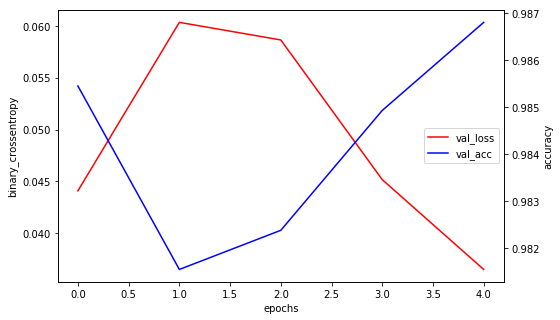

In [45]:
cnn_resnet50.visualization()

用全冻结层来进行预测：

In [46]:
cnn_resnet50.load_weight('resnet50_freeze_base.hdf5')

In [47]:
cnn_resnet50.predict(name = 'base')

98/98 [==============================] - 75s 770ms/step
Saving test result on: pred_resnet50base.csv
save_predict in: pred_resnet50base.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:135: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id     label
0          1  0.995000
1          2  0.995000
2          3  0.995000
3          4  0.995000
4          5  0.005000
5          6  0.005000
6          7  0.005000
7          8  0.005000
8          9  0.005000
9         10  0.005000
10        11  0.005000
11        12  0.995000
12        13  0.005000
13        14  0.005000
14        15  0.005000
15        16  0.005000
16        17  0.514038
17        18  0.995000
18        19  0.005000
19        20  0.005000
20        21  0.995000
21        22  0.005000
22        23  0.995000
23        24  0.995000
24        25  0.005000
25        26  0.995000
26        27  0.995000
27        28  0.005000
28        29  0.049955
29        30  0.995000
...      ...       ...
12470  12471  0.995000
12471  12472  0.995000
12472  12473  0.005000
12473  12474  0.005000
12474  12475  0.005000
12475  12476  0.995000
12476  12477  0.995000
12477  12478  0.431303
12478  12479  0.005000
12479  12480  0.005000
12480  12481  0.005000
12481  12482  0.005000
12482  12483  0.005000
12483  12484  0.995000
12484  12485  0.005000
12485  12486  0.995000
12486  12487  0.995000
12487  12488  0.995000
12488  12489  0.995000
12489  12490  0.991960
12490  12491  0.995000
12491  12492  0.995000
12492  12493  0.995000
12493  12494  0.995000
12494  12495  0.005000
12495  12496  0.005000
12496  12497  0.005000
12497  12498  0.995000
12498  12499  0.995000
12499  12500  0.005000

[12500 rows x 2 columns]

kaggle得分：

finetune最后25层，使用上面fit训练的最好的模型来进行finetune，finetune5次。

In [48]:
cnn_resnet50.fit_finetune(25, epochs = 5)

Epoch 1/5
1000/1000 [==============================] - 1848s 2s/step - loss: 0.0238 - acc: 0.9919 - val_loss: 0.0297 - val_acc: 0.9912

Epoch 00001: val_loss improved from inf to 0.02970, saving model to resnet50_finetune_25.hdf5
Epoch 2/5
1000/1000 [==============================] - 1828s 2s/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0419 - val_acc: 0.9912

Epoch 00002: val_loss did not improve from 0.02970
Epoch 3/5
1000/1000 [==============================] - 1827s 2s/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0438 - val_acc: 0.9920

Epoch 00003: val_loss did not improve from 0.02970
Epoch 4/5
1000/1000 [==============================] - 1829s 2s/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0402 - val_acc: 0.9916

Epoch 00004: val_loss did not improve from 0.02970
Epoch 5/5
1000/1000 [==============================] - 1829s 2s/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0483 - val_acc: 0.9919

Epoch 00005: val_loss did not improve from 0.02970


可视化：

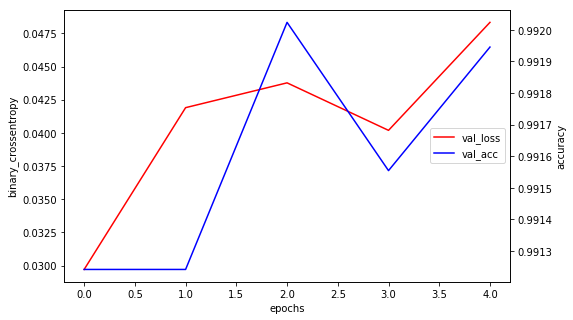

In [49]:
cnn_resnet50.visualization()

看下这个模型的测试结果：

In [50]:
cnn_resnet50.load_weight('resnet50_finetune_25.hdf5')

In [51]:
cnn_resnet50.predict(name = 'fine')

98/98 [==============================] - 75s 766ms/step
Saving test result on: pred_resnet50fine.csv
save_predict in: pred_resnet50fine.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:135: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id  label
0          1  0.995
1          2  0.995
2          3  0.995
3          4  0.995
4          5  0.005
5          6  0.005
6          7  0.005
7          8  0.005
8          9  0.005
9         10  0.005
10        11  0.005
11        12  0.995
12        13  0.005
13        14  0.005
14        15  0.005
15        16  0.005
16        17  0.995
17        18  0.995
18        19  0.005
19        20  0.005
20        21  0.995
21        22  0.005
22        23  0.995
23        24  0.995
24        25  0.005
25        26  0.995
26        27  0.995
27        28  0.005
28        29  0.995
29        30  0.995
...      ...    ...
12470  12471  0.995
12471  12472  0.995
12472  12473  0.005
12473  12474  0.005
12474  12475  0.005
12475  12476  0.995
12476  12477  0.995
12477  12478  0.995
12478  12479  0.005
12479  12480  0.005
12480  12481  0.005
12481  12482  0.005
12482  12483  0.005
12483  12484  0.995
12484  12485  0.005
12485  12486  0.995
12486  12487  0.995
12487  12488  0.995
12488  12489  0.995
12489  12490  0.995
12490  12491  0.995
12491  12492  0.995
12492  12493  0.995
12493  12494  0.995
12494  12495  0.005
12495  12496  0.005
12496  12497  0.005
12497  12498  0.995
12498  12499  0.995
12499  12500  0.005

[12500 rows x 2 columns]

在kaggle的成绩为：

将特征向量存取下来：

In [52]:
cnn_resnet50.write_feature(name = 'fine')

The output of model:  Tensor("global_average_pooling2d_2/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 151s 773ms/step
feature from test data ...
98/98 [==============================] - 75s 764ms/step
Write feature to file: feature_resnet50fine.hdf5


### 3. InceptionV3
训练冻结所有层的模型:

In [53]:
cnn_inceptionv3.fit(epochs= 5)

Epoch 1/5
650/650 [==============================] - 1266s 2s/step - loss: 0.2167 - acc: 0.9108 - val_loss: 0.0577 - val_acc: 0.9827

Epoch 00001: val_loss improved from inf to 0.05767, saving model to inception_v3_freeze_base.hdf5
Epoch 2/5
650/650 [==============================] - 1245s 2s/step - loss: 0.1610 - acc: 0.9340 - val_loss: 0.0646 - val_acc: 0.9823

Epoch 00002: val_loss did not improve from 0.05767
Epoch 3/5
650/650 [==============================] - 1245s 2s/step - loss: 0.1591 - acc: 0.9350 - val_loss: 0.0551 - val_acc: 0.9852

Epoch 00003: val_loss improved from 0.05767 to 0.05513, saving model to inception_v3_freeze_base.hdf5
Epoch 4/5
650/650 [==============================] - 1245s 2s/step - loss: 0.1568 - acc: 0.9358 - val_loss: 0.0559 - val_acc: 0.9847

Epoch 00004: val_loss did not improve from 0.05513
Epoch 5/5
650/650 [==============================] - 1245s 2s/step - loss: 0.1580 - acc: 0.9359 - val_loss: 0.0476 - val_acc: 0.9872

Epoch 00005: val_loss improv

可视化：

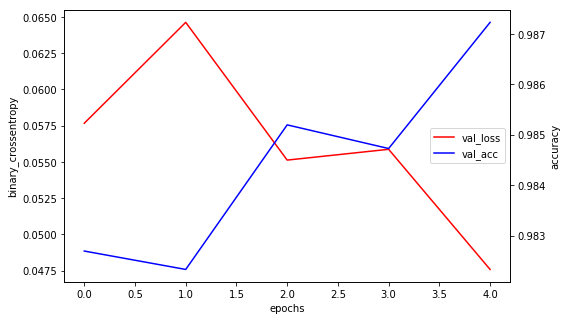

In [55]:
cnn_inceptionv3.visualization()

用全冻结层来进行预测：

In [57]:
cnn_inceptionv3.load_weight('inception_v3_freeze_base.hdf5')

In [58]:
cnn_inceptionv3.predict(name = 'base')

98/98 [==============================] - 72s 737ms/step
Saving test result on: pred_inception_v3base.csv
save_predict in: pred_inception_v3base.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:135: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id     label
0          1  0.995000
1          2  0.995000
2          3  0.995000
3          4  0.994107
4          5  0.005000
5          6  0.005000
6          7  0.005000
7          8  0.005000
8          9  0.005000
9         10  0.005000
10        11  0.005000
11        12  0.994886
12        13  0.005000
13        14  0.005000
14        15  0.005000
15        16  0.005000
16        17  0.995000
17        18  0.995000
18        19  0.005000
19        20  0.005000
20        21  0.995000
21        22  0.005000
22        23  0.995000
23        24  0.995000
24        25  0.005000
25        26  0.995000
26        27  0.995000
27        28  0.005000
28        29  0.005000
29        30  0.995000
...      ...       ...
12470  12471  0.995000
12471  12472  0.985911
12472  12473  0.005000
12473  12474  0.005000
12474  12475  0.005000
12475  12476  0.995000
12476  12477  0.995000
12477  12478  0.990138
12478  12479  0.005000
12479  12480  0.005000
12480  12481  0.067870
12481  12482  0.005000
12482  12483  0.005000
12483  12484  0.995000
12484  12485  0.005000
12485  12486  0.995000
12486  12487  0.995000
12487  12488  0.995000
12488  12489  0.995000
12489  12490  0.989509
12490  12491  0.950702
12491  12492  0.995000
12492  12493  0.986412
12493  12494  0.995000
12494  12495  0.005000
12495  12496  0.005000
12496  12497  0.005000
12497  12498  0.995000
12498  12499  0.995000
12499  12500  0.005000

[12500 rows x 2 columns]

kaggle得分：

finetune最后15层，使用上面fit训练的最好的模型来进行finetune，finetune5次。

In [59]:
cnn_inceptionv3.fit_finetune(15, epochs = 5)

Epoch 1/5
1000/1000 [==============================] - 1845s 2s/step - loss: 0.0907 - acc: 0.9648 - val_loss: 0.0679 - val_acc: 0.9876

Epoch 00001: val_loss improved from inf to 0.06789, saving model to inception_v3_finetune_15.hdf5
Epoch 2/5
1000/1000 [==============================] - 1829s 2s/step - loss: 0.0596 - acc: 0.9766 - val_loss: 0.0574 - val_acc: 0.9901

Epoch 00002: val_loss improved from 0.06789 to 0.05738, saving model to inception_v3_finetune_15.hdf5
Epoch 3/5
1000/1000 [==============================] - 1827s 2s/step - loss: 0.0481 - acc: 0.9817 - val_loss: 0.0723 - val_acc: 0.9874

Epoch 00003: val_loss did not improve from 0.05738
Epoch 4/5
1000/1000 [==============================] - 1835s 2s/step - loss: 0.0400 - acc: 0.9848 - val_loss: 0.0780 - val_acc: 0.9873

Epoch 00004: val_loss did not improve from 0.05738
Epoch 5/5
1000/1000 [==============================] - 1826s 2s/step - loss: 0.0331 - acc: 0.9873 - val_loss: 0.0772 - val_acc: 0.9884

Epoch 00005: val_l

可视化：

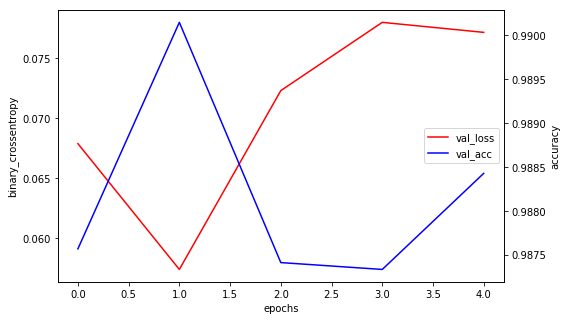

In [60]:
cnn_inceptionv3.visualization()

看下这个模型的测试结果：

In [61]:
cnn_inceptionv3.load_weight('inception_v3_finetune_15.hdf5')

In [62]:
cnn_inceptionv3.predict(name = 'fine')

98/98 [==============================] - 71s 724ms/step
Saving test result on: pred_inception_v3fine.csv
save_predict in: pred_inception_v3fine.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:135: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id     label
0          1  0.995000
1          2  0.995000
2          3  0.995000
3          4  0.995000
4          5  0.005000
5          6  0.005000
6          7  0.005000
7          8  0.005000
8          9  0.005000
9         10  0.005000
10        11  0.005000
11        12  0.995000
12        13  0.005000
13        14  0.005000
14        15  0.005000
15        16  0.005000
16        17  0.995000
17        18  0.995000
18        19  0.005000
19        20  0.005000
20        21  0.995000
21        22  0.005000
22        23  0.995000
23        24  0.995000
24        25  0.005000
25        26  0.991481
26        27  0.995000
27        28  0.005000
28        29  0.005000
29        30  0.995000
...      ...       ...
12470  12471  0.995000
12471  12472  0.995000
12472  12473  0.005000
12473  12474  0.005000
12474  12475  0.005000
12475  12476  0.995000
12476  12477  0.995000
12477  12478  0.995000
12478  12479  0.005000
12479  12480  0.005000
12480  12481  0.005000
12481  12482  0.005000
12482  12483  0.005000
12483  12484  0.995000
12484  12485  0.005000
12485  12486  0.995000
12486  12487  0.995000
12487  12488  0.995000
12488  12489  0.995000
12489  12490  0.995000
12490  12491  0.995000
12491  12492  0.995000
12492  12493  0.995000
12493  12494  0.995000
12494  12495  0.005000
12495  12496  0.005000
12496  12497  0.005000
12497  12498  0.995000
12498  12499  0.995000
12499  12500  0.005000

[12500 rows x 2 columns]

在kaggle的成绩为：

将特征向量存取下来：

In [63]:
cnn_inceptionv3.write_feature(name = 'fine')

The output of model:  Tensor("global_average_pooling2d_3/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 143s 735ms/step
feature from test data ...
98/98 [==============================] - 71s 729ms/step
Write feature to file: feature_inception_v3fine.hdf5


### fine-tune后的模型融合

In [68]:
import h5py
from sklearn.utils import shuffle

np.random.seed(23)

X_train = []
X_test = []
weight = [0.5, 0.2, 0.3]
for i, filename in enumerate(["feature_xceptionfine.hdf5", "feature_resnet50fine.hdf5", "feature_inception_v3fine.hdf5"]):
    with h5py.File(filename, 'r') as h:
        X_train.append(weight[i]*np.array(h['train']))
        X_test.append(weight[i]*np.array(h['test']))
        Y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, Y_train = shuffle(X_train, Y_train)

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [69]:
checkpoint = ModelCheckpoint("merge_fine.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]
result = model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_split=0.2, shuffle=True,
         callbacks=callbacks_list)

Train on 19948 samples, validate on 4987 samples
Epoch 1/10
19948/19948 [==============================] - 4s 197us/step - loss: 0.0445 - acc: 0.9913 - val_loss: 0.0086 - val_acc: 0.9990

Epoch 00001: val_loss improved from inf to 0.00860, saving model to merge_fine.h5
Epoch 2/10
19948/19948 [==============================] - 1s 52us/step - loss: 0.0075 - acc: 0.9988 - val_loss: 0.0052 - val_acc: 0.9994

Epoch 00002: val_loss improved from 0.00860 to 0.00520, saving model to merge_fine.h5
Epoch 3/10
19948/19948 [==============================] - 1s 52us/step - loss: 0.0050 - acc: 0.9992 - val_loss: 0.0039 - val_acc: 0.9994

Epoch 00003: val_loss improved from 0.00520 to 0.00388, saving model to merge_fine.h5
Epoch 4/10
19948/19948 [==============================] - 1s 52us/step - loss: 0.0041 - acc: 0.9991 - val_loss: 0.0032 - val_acc: 0.9994

Epoch 00004: val_loss improved from 0.00388 to 0.00318, saving model to merge_fine.h5
Epoch 5/10
19948/19948 [==============================] - 

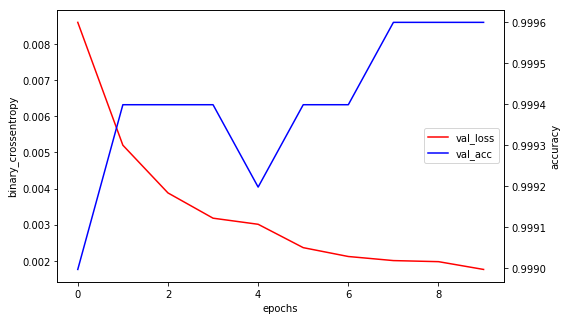

In [70]:
history = result.history
fig = plt.figure(figsize=(8, 5))

y1 = fig.add_subplot(111)
p1 = y1.plot(history['val_loss'], label="val_loss", color='r')
y1.set_ylabel('binary_crossentropy')
y1.set_xlabel('epochs')
y2 = y1.twinx()
p2 = y2.plot(history['val_acc'], label="val_acc", color='b')
y2.set_ylabel('accuracy')
lns = p1+p2
labs = [l.get_label() for l in lns]
y1.legend(lns, labs, loc='center right')
plt.show()

In [71]:
#导入模型权重，并进行预测    
model.load_weights('merge_fine.h5')
y_test = model.predict(X_test, verbose=1)
y_test = y_test.clip(min=0.005, max=0.995)
df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(img_test, (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_test[i])

df.to_csv('pred-merge-fine.csv', index=None)
df.head(10)

12500/12500 [==============================] - 2s 161us/step
Found 12500 images belonging to 1 classes.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005